In [15]:
%matplotlib notebook

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# set path to SpectralEvents if necessary
#sys.path.append('/home/ryan/SpectralEvents')
import spectralevents_functions as se

In [3]:
# dataset parameters
data_dir = 'data'  # relative path to data directory
subj_ids = [str(id) for id in range(1, 10 + 1)]  # subject IDs 1-10

n_subjs = len(subj_ids)  # number of subjects
n_trials = 200           # number of trials per subject
n_times = 600            # number of time samples per trial
samp_freq = 600          # sampling rate (Hz)

In [4]:
# load data
hit_trials = list()
data = list()
for id_idx, id in enumerate(subj_ids):
    fname = op.join(data_dir, 'prestim_humandetection_600hzMEG_subject' + id + '.mat')
    raw_data = loadmat(fname)
    hit_trials.append(np.nonzero(raw_data['YorN'].squeeze()))  # indices of hit trials
    data.append(raw_data['prestim_raw_yes_no'])  # MEG time series (trials x samples)

In [5]:
# investigate data structure
data[0].shape  # trials x samples for Subj 1

(200, 600)

In [6]:
# set time-frequency response (TFR) parameters
freqs = list(range(1, 60 + 1))   # TFR: fequency values (Hz) over which to calculate
times = np.arange(n_times) / samp_freq
morlet_width = 7  # TFR: width parameter of Morlet wavelet

In [7]:
# calculate time-frequency response (TFR)
tfrs = np.zeros((n_subjs, n_trials, len(freqs), n_times))
tfrs_norm = np.zeros_like(tfrs)

for subj_idx, subj_data in enumerate(data):

    # calculate TFR using the Morlet wavelet method
    tfr = se.spectralevents_ts2tfr(subj_data, freqs, samp_freq, morlet_width)
    tfrs[subj_idx, :, :, :] = tfr

    # normalize the TFR data [tr x f x t] to the median value per frequency band
    tfr_norm = se.tfr_normalize(tfr)
    tfrs_norm[subj_idx, :, :, :] = tfr_norm

In [8]:
# set spectral event analysis parameters
event_band = [15, 29]  # frequency range (Hz) of spectral events (beta band)
thresh_FOM = 6;  # Factors of Median threshold (see Shin et al. eLife 2017 for details concerning this value)

In [9]:
# run spectral event analysis per subject
spec_events_all = list()

for subj_idx, subj_data in enumerate(data):
    tfr = tfrs[subj_idx]

    # find local maxima in TFR
    spec_events = se.find_events(event_band, thresh_FOM, times, freqs, tfr, samp_freq)
    spec_events_all.append(spec_events)


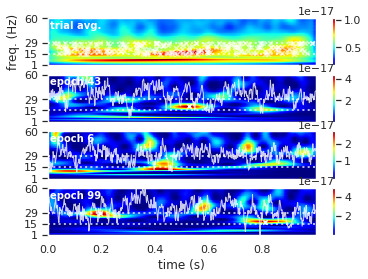

In [21]:
fig = se.plot_avg_spectrogram(spec_events=spec_events,
                              TFR=tfr, times=times, freqs=freqs,
                              event_band=event_band, timeseries=subj_data,
                              example_epochs=[43, 6, 99], vlim=None)  # try vlim=[0, 1.0e-17]